In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

%matplotlib inline

In [2]:
#——————————————————1. 导入数据——————————————————————
f=open('dataset_1.csv')  
df=pd.read_csv(f)     #读入股票数据

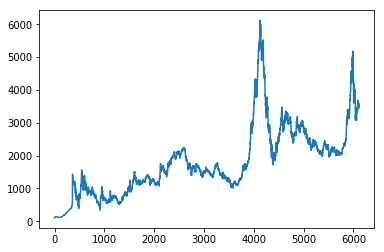

In [3]:
data=np.array(df['max'])   #获取最高价序列
data=data[::-1]      #反转，使数据按照日期先后顺序排列
#以折线图展示data
plt.figure()
plt.plot(data)
plt.show()

In [4]:
normalize_data=(data-np.mean(data))/np.std(data)  #标准化
normalize_data=normalize_data[:,np.newaxis]  #增加维度

In [5]:
len(normalize_data)

6111

In [6]:
#形成训练集
#设置常量
time_step=20      #时间步
rnn_unit=10       #hidden layer units
batch_size=60     #每一批次训练多少个样例
input_size=1      #输入层维度
output_size=1     #输出层维度
lr=0.0006         #学习率
train_x,train_y=[],[]   #训练集
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 

In [18]:
len(train_x)

6090

In [ ]:
#——————————————————定义神经网络变量——————————————————
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

In [ ]:
#——————————————————定义神经网络变量——————————————————
def lstm(batch):      #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [ ]:
#——————————————————训练模型——————————————————
def train_lstm():
    global batch_size
    pred,_=lstm(batch_size)
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #重复训练10000次
        for i in range(10000):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size
                #每10步保存一次参数
                if step%10==0:
                    print(i,step,loss_)
                    print("保存模型：",saver.save(sess,'stock.model'))
                step+=1


train_lstm()

In [20]:
#————————————————预测模型————————————————————
def prediction():
    pred,_=lstm(1)      #预测时只输入[1,time_step,input_size]的测试数据
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint(base_path+'module2/')
        saver.restore(sess, module_file) 

        #取训练集最后一行为测试样本。shape=[1,time_step,input_size]
        prev_seq=train_x[-1]
        predict=[]
        #得到之后100个预测结果
        for i in range(100):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        #以折线图表示结果
#         plt.figure()
#         plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
#         plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
#         plt.show()

prediction() 

NameError: name 'lstm' is not defined

# Updated version that can directly be run